In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from PIL import Image
import os
import warnings

warnings.filterwarnings('ignore')

In [15]:
# Define dataset path
dataset_path = "att_faces"

images = []
labels = []

for subject_id in range(1, 41):  # 40 subjects
    subject_folder = os.path.join(dataset_path, f's{subject_id}')
    for image_id in range(1, 11):  # 10 images per subject
        image_path = os.path.join(subject_folder, f'{image_id}.pgm')
        if os.path.exists(image_path):
            img = Image.open(image_path).convert('L')
            img_array = np.array(img)
            images.append(img_array.flatten())
            labels.append(subject_id - 1)

images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images with shape {images[0].shape}")

Loaded 400 images with shape (10304,)


In [3]:
image_shape = (112, 92)

images = images.astype(np.float64)
mean_face = np.mean(images, axis=0)
centered_images = images - mean_face

In [4]:
n_samples, n_features = centered_images.shape
n_components = 200

X_centered = centered_images - np.mean(centered_images, axis=0)
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

eigenvalues = (S ** 2) / (n_samples - 1)
eigenfaces = Vt[:n_components].T  # Each column is a principal component

print(f"PCA computed: {eigenfaces.shape[1]} components")

PCA computed: 200 components


In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)

X_train_centered = X_train - mean_face
X_test_centered = X_test - mean_face

In [6]:
train_proj = np.dot(X_train_centered, eigenfaces)
test_proj = np.dot(X_test_centered, eigenfaces)

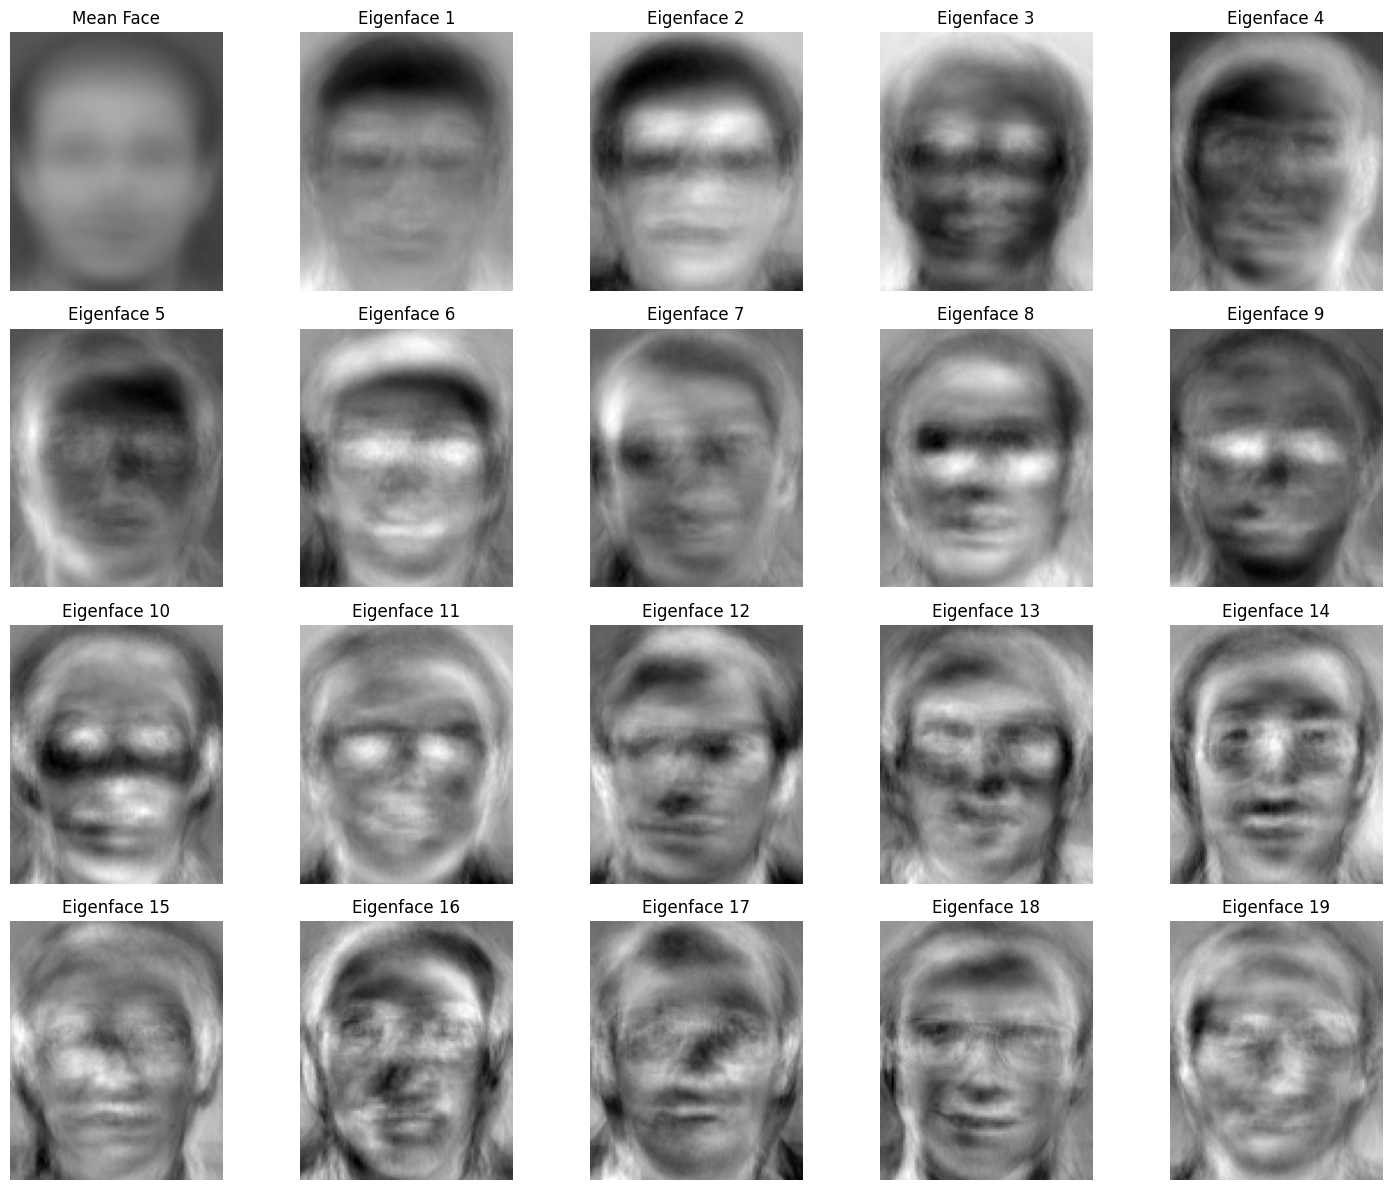

In [7]:
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

axes[0, 0].imshow(mean_face.reshape(image_shape), cmap='gray', vmin=0, vmax=255)
axes[0, 0].set_title('Mean Face')
axes[0, 0].axis('off')

for i in range(1, 20):
    row, col = i // 5, i % 5
    
    ef = eigenfaces[:, i - 1]
    ef_min, ef_max = ef.min(), ef.max()
    ef_norm = 255 * (ef - ef_min) / (ef_max - ef_min + 1e-6)

    axes[row, col].imshow(ef_norm.reshape(image_shape), cmap='gray')
    axes[row, col].set_title(f"Eigenface {i}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

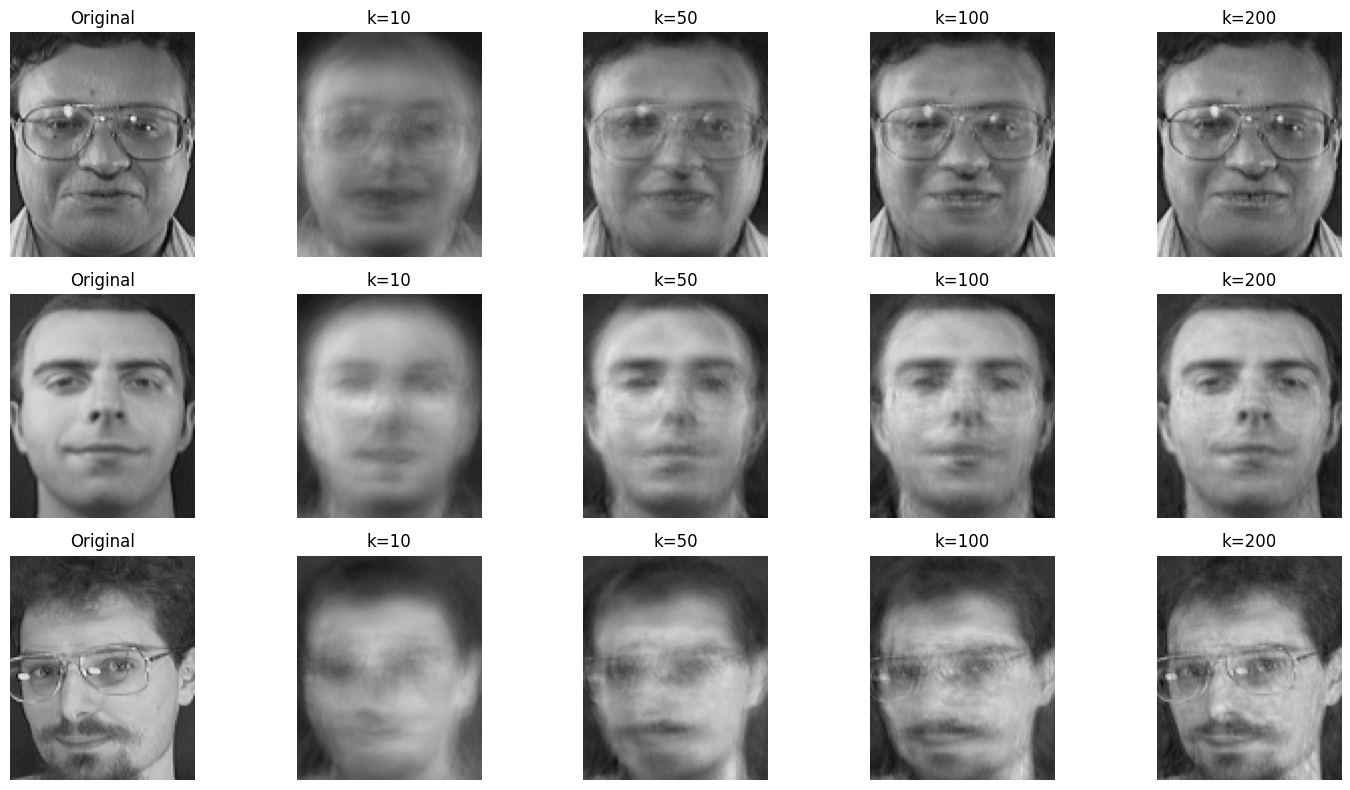

In [8]:
test_indices = [0, 1, 2]
k_values = [10, 50, 100, 200]

fig, axes = plt.subplots(len(test_indices), len(k_values) + 1, figsize=(15, 8))

for i, idx in enumerate(test_indices):
    axes[i, 0].imshow(X_test[idx].reshape(image_shape), cmap='gray', vmin=0, vmax=255)
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')
    
    for j, k in enumerate(k_values):
        proj = np.dot(X_test_centered[idx:idx+1], eigenfaces[:, :k])
        recon = np.dot(proj, eigenfaces[:, :k].T) + mean_face
        axes[i, j+1].imshow(recon[0].reshape(image_shape), cmap='gray', vmin=0, vmax=255)
        axes[i, j+1].set_title(f'k={k}')
        axes[i, j+1].axis('off')

plt.tight_layout()
plt.show()

In [9]:
k_values = [5, 10, 20, 50, 100, 150, 200]
accuracies = []

for k in k_values:
    test_proj_k = test_proj[:, :k]
    train_proj_k = train_proj[:, :k]
    
    distances = cdist(test_proj_k, train_proj_k, metric='euclidean')
    nearest_indices = np.argmin(distances, axis=1)
    y_pred = y_train[nearest_indices]
    
    acc = np.mean(y_pred == y_test)
    accuracies.append(acc)
    print(f"k = {k:3d} => Accuracy = {acc:.4f}")

k =   5 => Accuracy = 0.8583
k =  10 => Accuracy = 0.9333
k =  20 => Accuracy = 0.9500
k =  50 => Accuracy = 0.9667
k = 100 => Accuracy = 0.9667
k = 150 => Accuracy = 0.9500
k = 200 => Accuracy = 0.9583


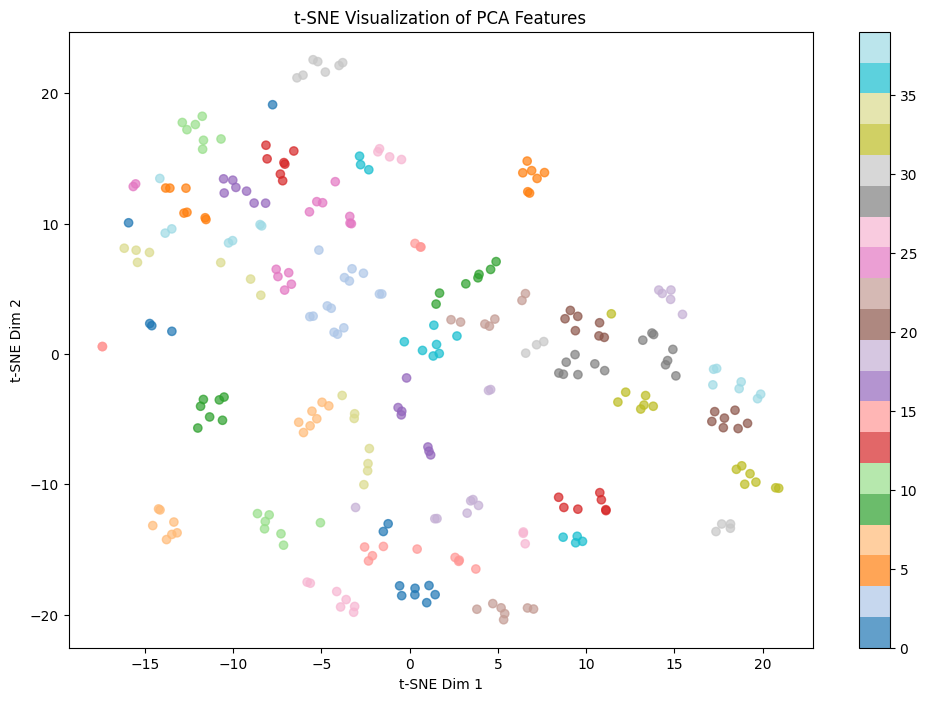

In [10]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(train_proj[:, :50])

plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_train, cmap='tab20', alpha=0.7)
plt.colorbar(scatter)
plt.title('t-SNE Visualization of PCA Features')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.show()

In [11]:
best_k = k_values[np.argmax(accuracies)]
best_acc = max(accuracies)

print(f"Best Accuracy: {best_acc:.4f} at k = {best_k}")
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
print("Top 10 Explained Variance Ratios:")
print(explained_variance_ratio[:10])

print(f"Cumulative variance (first 50 components): {np.sum(explained_variance_ratio[:50]):.4f}")


Best Accuracy: 0.9667 at k = 50
Top 10 Explained Variance Ratios:
[0.1760955  0.12906636 0.06841042 0.05578943 0.05109913 0.03362534
 0.02447197 0.02331064 0.01962202 0.01802781]
Cumulative variance (first 50 components): 0.8161
